In [62]:
from multiprocessing import Pool, cpu_count
from src.utility import *
from src.Manufactory import *
from tqdm.notebook import tqdm

worker_count = max(cpu_count() - 1, 1)
print('number of processors: ', worker_count)

number of processors:  10


# Static Spin Hamiltonian

The interaction Hamiltonian is $$H_0 = \omega_I I_z + AS_zI_z + B_xS_zI_x + B_yS_zI_y$$
where $A$ is positive and $\omega_I$ is negative.

In [23]:
# Hyperfine constants
A = 2*np.pi * 1e-3 * (35.2)
B = 2*np.pi * 1e-3 * 70.4

# omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us
omega_L = -790.40/1000*2*np.pi

## Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

# Magnetic field
B0 = 0.447 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

S = 1/2
nS = int(2*S+1)
(Sx,Sy,Sz) = generate_S(S)

I = 1/2
nI = int(2*I+1)
(Ix,Iy,Iz) = generate_S(I)

# Local oscillator at 10 MHz
omega_LO = 2*np.pi*0 # set to zero for now
H_LO = tensor(omega_LO*Sz, qeye(nI))

# Nuclear Zeeman interaction
H_NZ = tensor(qeye(nS), omega_L*Iz)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A*tensor(Sz,Iz) + B*tensor(Sz,Ix)

# Total static Hamiltonian
H0 = (H_LO + H_NZ + H_DD)

In [24]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-2.4278228   0.11058406  0.          0.        ]
 [ 0.11058406  2.4278228   0.          0.        ]
 [ 0.          0.         -2.53840686 -0.11058406]
 [ 0.          0.         -0.11058406  2.53840686]]

In [25]:
H0.eigenstates()[1]

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.        ]
        [0.        ]
        [0.99976308]
        [0.02176669]]                                                     ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.99974103]
        [-0.02275663]
        [ 0.        ]
        [ 0.        ]]                                                    ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.02275663]
        [0.99974103]
        [0.        ]
        [0.        ]]                                                     ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.        ]
        [ 0.        ]
        [-0.02176669]
        [ 0.99976308]]                                                    ],
      dtype=object)

## Dressed State Operators

In [8]:
# dressed states
ud_basis = H0.eigenstates()[1][2]
uu_basis = H0.eigenstates()[1][1]
dd_basis = H0.eigenstates()[1][3]
du_basis = H0.eigenstates()[1][0]

In [9]:
# energy relaxation
sigmam_nuclear_up = du_basis * uu_basis.dag()
sigmam_nuclear_down = dd_basis * ud_basis.dag()
cross_nuclear_d2u = du_basis * ud_basis.dag()
cross_nuclear_u2d = dd_basis * uu_basis.dag()

In [13]:
Sz_dressed = uu_basis * uu_basis.dag() + ud_basis * ud_basis.dag() - du_basis * du_basis.dag() - dd_basis * dd_basis.dag()
Sz_dressed

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

In [16]:
def get_freq_difference(high_freq_state, low_freq_state):
    """
    get the frequency difference between two levels
    """
    return (H0.eigenstates()[0][high_freq_state]-H0.eigenstates()[0][low_freq_state])*1000/2/np.pi
get_freq_difference(0, 3)

-808.7663692315599

# Decay of a Superposition State

In [17]:
ket0 = (uu_basis + ud_basis)/np.sqrt(2)
t = np.linspace(0, 1200, 1000)
gamma_R = (0.8*1000)**-1 # (0.8 ms)**-1
c_ops = [np.sqrt(gamma_R) * tensor(sigmam(), qeye(nS))]
# c_ops = [np.sqrt(gamma_R) * sigmam_nuclear_up, np.sqrt(gamma_R) * sigmam_nuclear_down]

result = mesolve(H0, ket0, t, c_ops, [])

S_x = expect(tensor(Sx, qeye(nI)), result.states)
S_y = expect(tensor(Sy, qeye(nI)), result.states)
S_z = expect(tensor(Sz, qeye(nI)), result.states)
I_x = expect(tensor(qeye(nS), Ix), result.states)
I_y = expect(tensor(qeye(nS), Iy), result.states)
I_z = expect(tensor(qeye(nS), Iz), result.states)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.72301503]
 [0.6908323 ]
 [0.        ]
 [0.        ]]

In [18]:
def decay_sin_fit(t,f,t0,a,b):
    return a*(np.sin(2*np.pi*f*t + b)) * np.exp(-t/t0) 
def exp_decay(t,t0,a,b):
    return a * np.exp(-t/t0) + b

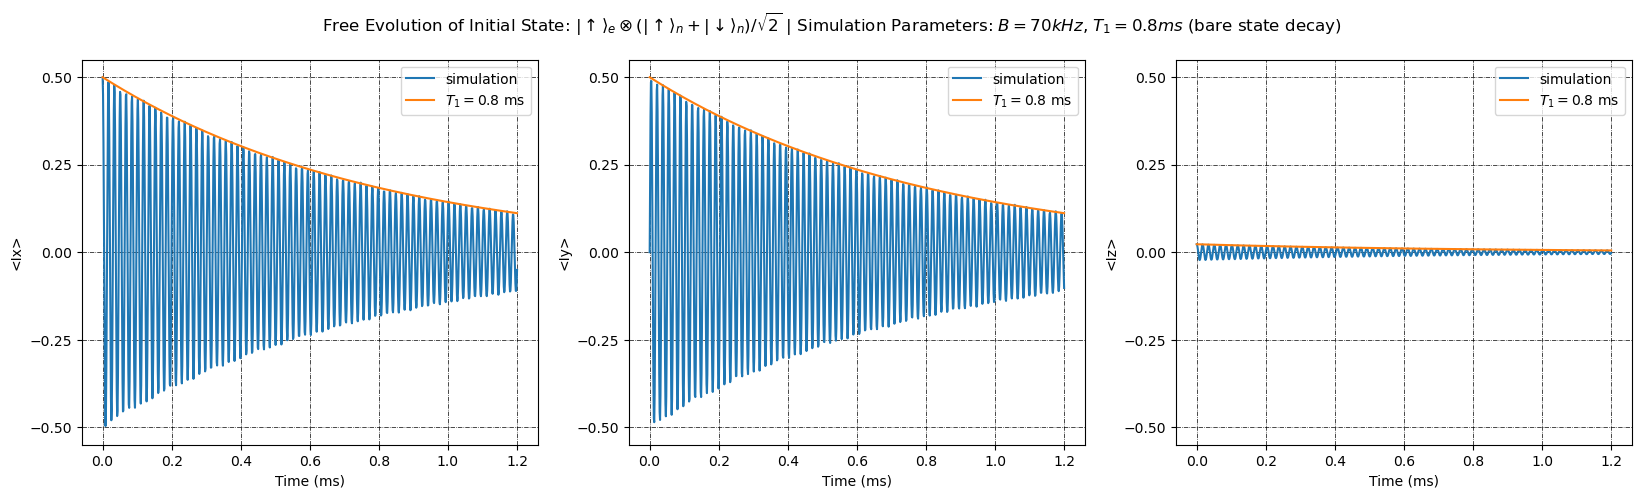

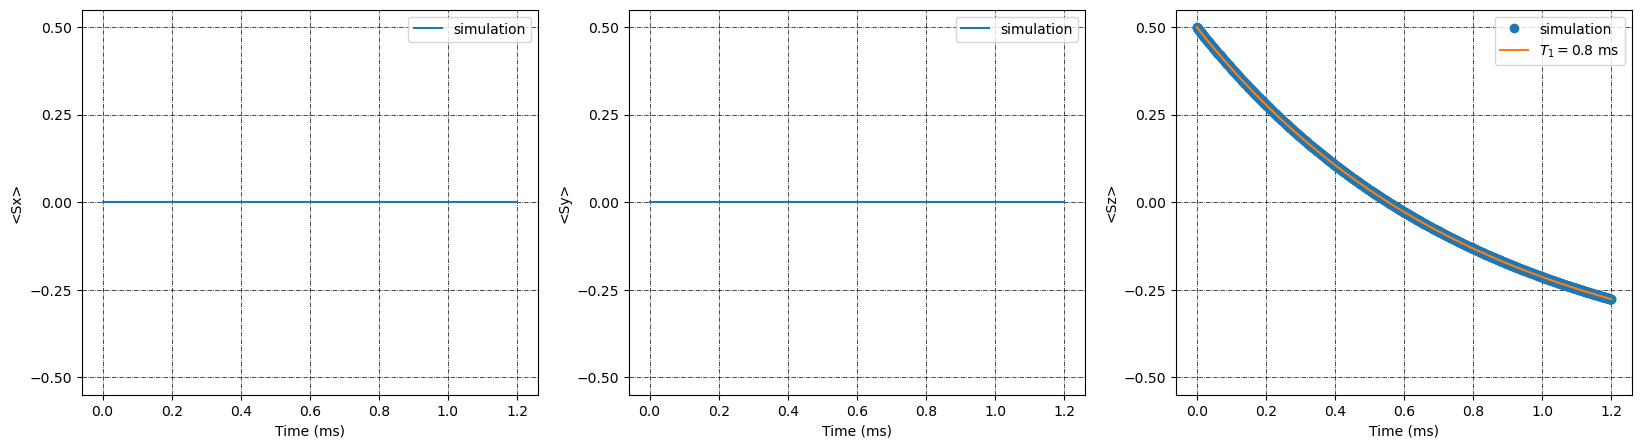

In [19]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(r"Free Evolution of Initial State: $|\uparrow\rangle_e \otimes (|\uparrow\rangle_n + |\downarrow\rangle_n)/\sqrt{2}$ | Simulation Parameters: $B=%.f kHz$, $T_1=%.1f ms$ (bare state decay)"%(B*1000/2/np.pi, 1/gamma_R/1000))

ax1.plot(t/1000, I_x, '-', label = 'simulation')
ax1.plot(t/1000, exp_decay(t/1000, *[0.8,0.5,0]), '-', label = "$T_1 = 0.8$ ms")
ax1.grid(color='k', linestyle='-.', linewidth=0.5)
ax1.set_ylim([-0.55, 0.55])
ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax1.set(xlabel = "Time (ms)", ylabel = "<Ix>")
ax1.legend()

ax2.plot(t/1000, I_y, '-', label = 'simulation')
ax2.plot(t/1000, exp_decay(t/1000, *[0.8,0.5,0]), '-', label = "$T_1 = 0.8$ ms")
ax2.grid(color='k', linestyle='-.', linewidth=0.5)
ax2.set_ylim([-0.55, 0.55])
ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
ax2.set(xlabel = "Time (ms)", ylabel = "<Iy>")
ax2.legend()

ax3.plot(t/1000, I_z, '-', label = 'simulation')
ax3.plot(t/1000, exp_decay(t/1000, *[0.8,max(I_z),0]), '-', label = "$T_1 = 0.8$ ms")
ax3.grid(color='k', linestyle='-.', linewidth=0.5)
ax3.set_ylim([-0.55, 0.55])
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set(xlabel = "Time (ms)", ylabel = "<Iz>")
ax3.legend()


%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(t/1000, S_x, '-', label = 'simulation')
# ax1.plot(t/1000, exp_decay(t/1000, *[0.8,0.5]), '-', label = "$T_1 = 0.8$ ms")
ax1.grid(color='k', linestyle='-.', linewidth=0.5)
ax1.set_ylim([-0.55, 0.55])
ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax1.set(xlabel = "Time (ms)", ylabel = "<Sx>")
ax1.legend()

ax2.plot(t/1000, S_y, '-', label = 'simulation')
# ax2.plot(t/1000, exp_decay(t/1000, *[0.8,0.5]), '-', label = "$T_1 = 0.8$ ms")
ax2.grid(color='k', linestyle='-.', linewidth=0.5)
ax2.set_ylim([-0.55, 0.55])
ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
ax2.set(xlabel = "Time (ms)", ylabel = "<Sy>")
ax2.legend()

guess = [1, 0.5, -0.5]
popt, pcov = curve_fit(exp_decay, t/1000, S_z, guess)
ax3.plot(t/1000, S_z, 'o', label = 'simulation')
ax3.plot(t/1000, exp_decay(t/1000, *popt), '-', label = "$T_1 = %.1f$ ms"%(popt[0]))
ax3.grid(color='k', linestyle='-.', linewidth=0.5)
ax3.set_ylim([-0.55, 0.55])
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set(xlabel = "Time (ms)", ylabel = "<Sz>")
ax3.legend()


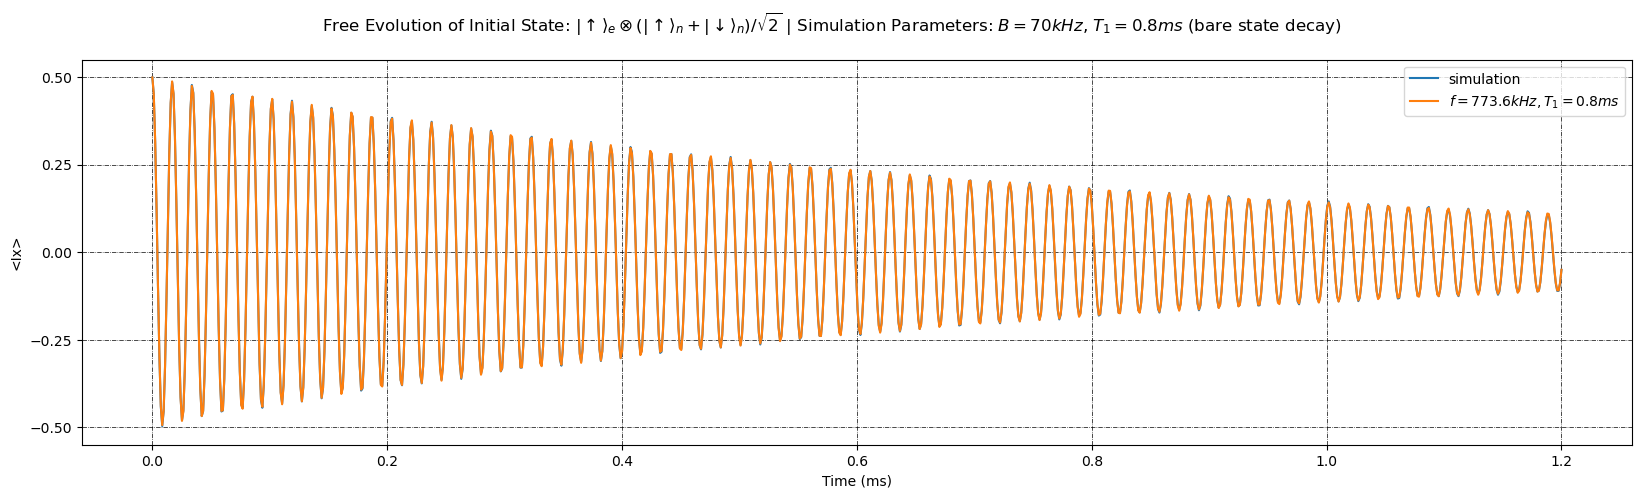

In [20]:
%matplotlib inline
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle(r"Free Evolution of Initial State: $|\uparrow\rangle_e \otimes (|\uparrow\rangle_n + |\downarrow\rangle_n)/\sqrt{2}$ | Simulation Parameters: $B=%.f kHz$, $T_1=%.1f ms$ (bare state decay)"%(B*1000/2/np.pi, 1/gamma_R/1000))

guess = [775, 0.8, 0.5, np.pi/2]
popt, pcov = curve_fit(decay_sin_fit, t/1000, I_x, guess)

ax1.plot(t/1000, I_x, '-', label = 'simulation')
ax1.plot(t/1000, decay_sin_fit(t/1000, *popt), '-', label = "$f = %.1f kHz, T_1 = %.1f ms$"%(popt[0], popt[1]))
ax1.grid(color='k', linestyle='-.', linewidth=0.5)
# ax1.set_xlim([0, 0.05])
ax1.set_ylim([-0.55, 0.55])
ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax1.set(xlabel = "Time (ms)", ylabel = "<Ix>")
ax1.legend()


# Allowed Rabi

In [54]:
drive_amp_convert = 107/0.05
n_points = 50
amp = 0.050*drive_amp_convert*2*np.pi/1000
pulse_duration = np.linspace(1, 50, n_points)

H_flattop_p = [tensor(sigmap(),qeye(nI)), square_pulse_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), square_pulse_m]
ket0 = H0.eigenstates()[1][3] # When the last 2 components of the state vector are nil, the electron spin is in the ground state
H = [H0, H_flattop_p, H_flattop_m]

pool = Pool(worker_count//2)

args = [(H, ket0, 0, amp, A, dur, Sz, nI) for dur in pulse_duration]

sz_flattop = pool.starmap(mp_get_allowed_rabi, args)

pool.close()

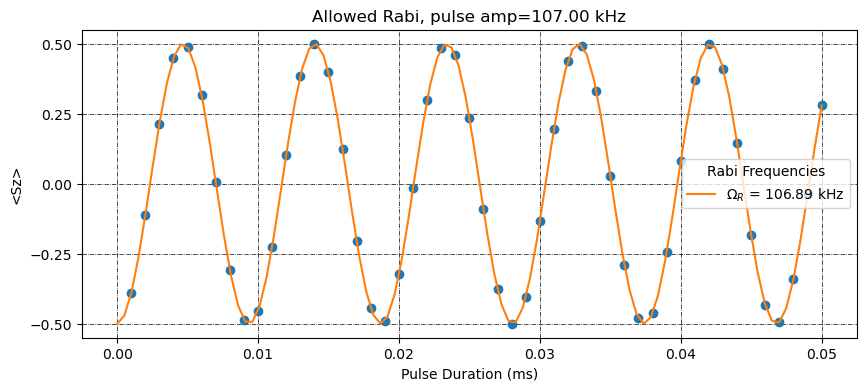

In [55]:
def rabi_fit(t,f,a,b,c):
    return a*(b + np.cos(2*np.pi*f*t+c))

fit_axis = np.linspace(0, pulse_duration[-1]/1000, 100)

plt.figure(figsize = (10,4))

guess = [0.05*drive_amp_convert, -0.5, 0, 0]
popt, pcov = curve_fit(rabi_fit, pulse_duration/1000, sz_flattop, guess)

plt.title("Allowed Rabi, pulse amp=%.2f kHz"%(amp/2/np.pi*1000))
plt.plot(pulse_duration/1000, sz_flattop, 'o')
plt.plot(fit_axis, rabi_fit(fit_axis, *popt), '', alpha=1, label="$\Omega_R$ = %.2f kHz"%(popt[0]))

plt.xlabel("Pulse Duration (ms)")
plt.ylabel("<Sz>")
plt.grid(color='k', linestyle='-.', linewidth=0.5)
plt.ylim(-0.55, 0.55)
plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.legend(title = 'Rabi Frequencies')

In [75]:
def get_allowed_rabi_cheveron(allowed_chevron_det, amp, pulse_duration):
    chevron_rabi = []
    for det in (tqdm(allowed_chevron_det)):
        pool = Pool(worker_count//2)

        args = [(H, ket0, det, amp, A, dur, Sz, nI) for dur in pulse_duration]

        rab_ft = pool.starmap(mp_get_allowed_rabi, args)

        pool.close()

        chevron_rabi.append(rab_ft)
    return chevron_rabi
pulse_duration = np.linspace (0, 30, 300)
allowed_chevron_det = np.linspace(-200, 200, 300)/1e3*2*np.pi
allowed_rabi_cheveron = get_allowed_rabi_cheveron(allowed_chevron_det, amp, pulse_duration)

  0%|          | 0/300 [00:00<?, ?it/s]

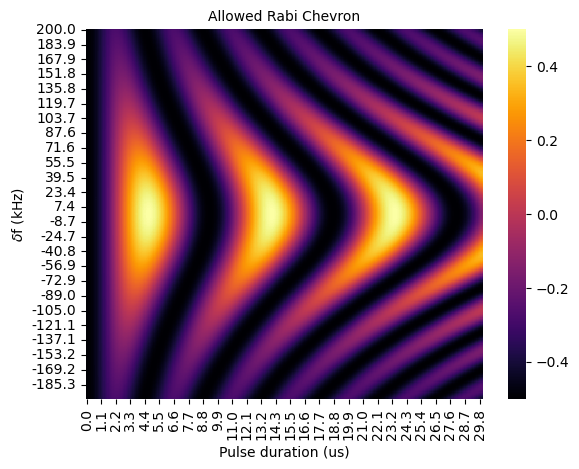

In [76]:
import seaborn as sns
import pandas as pd

def plot_2d_sweep(data,x=[],y=[],xlabel = '',ylabel = '',clabel = '',title = '',xtick = 'auto',ytick = 'auto',
                  centre = None,vmin = None,vmax = None,cmap = sns.diverging_palette(240, 10, n=361),
                  horizontal_ticks = False, fontsize = None):
    """
    Generic plotting function for 2D datasets
    """
    if len(x)==0: x = np.linspace(0, data.shape[1]-1, data.shape[1], dtype = int)
    if len(y)==0: y = np.linspace(0, data.shape[0]-1, data.shape[0], dtype = int)
    fieldsweep_df = pd.DataFrame(data=np.flip(data,axis = 0),index=np.flip(y,axis = 0),columns=x)
    #else: fieldsweep_df = pd.DataFrame(data=data)
    # fieldsweep_df = data
    ax = sns.heatmap(fieldsweep_df, xticklabels = xtick, yticklabels = ytick,cmap = cmap,center = centre,vmin = vmin, vmax = vmax)#,center = -100,cmap = sns.diverging_palette(240, 10, n=361))
    ax.collections[0].colorbar.set_label(clabel, fontsize = fontsize)
    ax.collections[0].colorbar.ax.tick_params(labelsize=fontsize)
    plt.tick_params(labelsize = fontsize)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    if horizontal_ticks == True:
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(title, fontsize = fontsize)
x = ['%.1f'%i for i in pulse_duration]
y = ['%.1f'%i for i in allowed_chevron_det*1e3/2/np.pi]

plot_2d_sweep(allowed_rabi_cheveron,x,y,xlabel = 'Pulse duration (us)',ylabel = r'$\delta$f (kHz)',clabel = '',title = 'Allowed Rabi Chevron',xtick = 'auto',ytick = 'auto',
                  centre = None,vmin = None,vmax = None,cmap = 'inferno',
                  horizontal_ticks = False, fontsize = None)

# Raman Rabi

## Spectroscopy

In [82]:
Delta = 1.566*2*np.pi# MHz * 2pi
allowed_detuning = 1400/1000*2*np.pi         # MHz * 2pi
sideband_detuning = (809+1400)/1000*2*np.pi         # MHz * 2pi
kappa = 4.41        # us-1
allowed_cavity_filter = 1/np.sqrt(1+(2*allowed_detuning/kappa)**2)
sideband_cavity_filter = 1/np.sqrt(1+(2*sideband_detuning/kappa)**2)
drive_amp_convert = 107/0.05 # conversion between drive amp in kHz and relative amp 

electron_amplitude = 0.1
sideband_amplitude = 0.8

sigma_raise = 1000
amp1 = sideband_amplitude*drive_amp_convert*sideband_cavity_filter /1000*2*np.pi # MHz * 2pi
amp2 = electron_amplitude*drive_amp_convert*allowed_cavity_filter /1000*2*np.pi # MHz * 2pi
pulse_duration = 10000

detuning = np.linspace(807.5, 810.0, 70)/1000*2*np.pi

print(amp1*1e3/2/np.pi, amp2*1e3/2/np.pi)

268.61130458392955 52.033321118230056


In [83]:
pulses, args_pulses = [], []
############## Sideband ##############
pulses.append('s')
args_pulses.append({
    'sigma_raise': sigma_raise,
    'pulse_duration': pulse_duration,
    'amplitude': amp1,
    't0': 0,
    'detuning': 0,
    'phase': 0,
})

############## Allowed ##############
pulses.append('s')
args_pulses.append({
    'sigma_raise': sigma_raise,
    'pulse_duration': pulse_duration,
    'amplitude': amp2,
    't0': 0,
    'detuning': 0,
    'phase': 0,
})

seq_args = {"pulses": pulses, "args_pulses": args_pulses}

H_flattop_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
H_flattop_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]
H = [H0, H_flattop_p, H_flattop_m]
ket0 = H0.eigenstates()[1][3]




import time
start_time = time.time()

pool = Pool(worker_count)

args = [(H, ket0, pulse_duration, sigma_raise, det, -A, Delta, seq_args, Sz, nS) for det in detuning]
    
I_z = pool.starmap(mp_raman_spec_s, args)
    
pool.close()

end_time = time.time()
print("Run time: %.2f min"%((end_time - start_time)/60))

Run time: 2.28 min


In [72]:
# np.savetxt('single_nucleus_simulation_data/detuning_%.f_%.f_%.f.txt'%(Delta/2/np.pi*1000, amp1/2/np.pi*1000, amp2/2/np.pi*1000), detuning)
# np.savetxt('single_nucleus_simulation_data/raman_spec_%.f_%.f_%.f.txt'%(Delta/2/np.pi*1000, amp1/2/np.pi*1000, amp2/2/np.pi*1000), I_z)

In [30]:
def get_peak_center(freq, spec):
    """
    take the average of the positions of the two highest peaks the peak center
    """
    min1 = np.argmax(spec) # index of min value
    temp = spec[min1]
    spec[min1] = -100 # set to some large value
    min2 = np.argmax(spec) # index of second min value
    spec[min1] = temp
    return (freq[min1] + freq[min2])/2
def rabi_fit(t,f,a,b,c):
    return a*(b + np.cos(2*np.pi*f*t+c))
def Lorentzian(x, cen, wid, amp, b):
    return amp*wid**2/((x-cen)**2+wid**2) + b
def sinc_fit(x, cen, wid, t):
    return -wid**2/((x-cen)**2+wid**2) * np.sinc(2*np.pi*t*np.sqrt((x-cen)**2)/2)**2 + 0.5
def chevron(x, cen, wid, t):
    return wid**2/((x-cen)**2+wid**2) * np.sin(2*np.pi*t*np.sqrt((x-cen)**2+wid**2)/2)**2 - 0.5

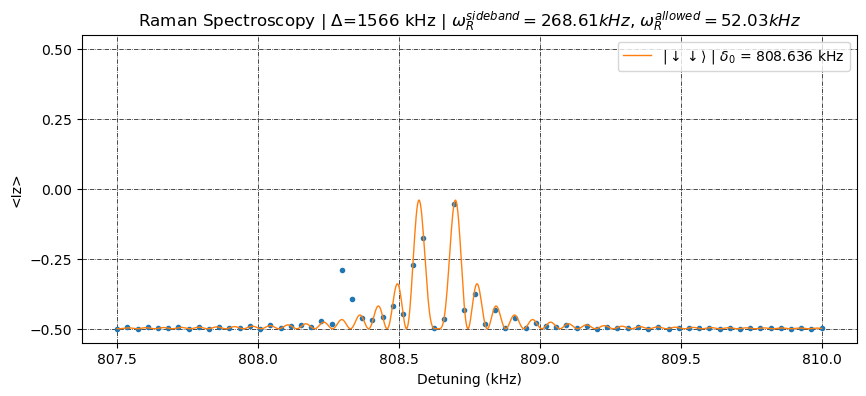

In [84]:
# detuning = np.loadtxt('single_nucleus_simulation_data/detuning.txt')
# I_z = np.loadtxt('single_nucleus_simulation_data/raman_spec_%.f_%.f_%.f.txt'%(Delta/2/np.pi*1000, amp1/2/np.pi*1000, amp2/2/np.pi*1000))

plt.figure(figsize=(10,4))
x = detuning/2/np.pi*1000 # to kHz
fit_axis = np.linspace(x[0],x[-1],1000)
raman_rabi_freq_guess = amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/abs(Delta*1000/2/np.pi) - amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/(abs(Delta*1000/2/np.pi)+774)
chevron_guess = [get_peak_center(x, I_z), raman_rabi_freq_guess, 16]
# guess = [get_peak_center(x, I_z), 0.1, -0.5, np.max(I_z)]
guess = [x[np.argmin(I_z)], amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/14000, -0.5, np.max(I_z)]
popt, pcov = curve_fit(chevron, x, I_z, chevron_guess)
label = r'$|\downarrow\downarrow\rangle$ | $\delta_0$ = %.3f kHz'%(popt[0])
plt.plot(x, I_z, 'o', markersize = 3)
plt.plot(fit_axis, chevron(fit_axis, *popt), alpha = 1, linewidth = 1, label = label)

resonant_freq = popt[0]*2*np.pi/1000 # MHz * 2pi

plt.title("Raman Spectroscopy | $\Delta$=%.f kHz | $\omega_{R}^{sideband}=%.2f kHz$, $\omega_{R}^{allowed}=%.2f kHz$"%(Delta*1000/2/np.pi,amp1/2/np.pi*1000, amp2/2/np.pi*1000))
plt.grid(color='k', linestyle='-.', linewidth=0.5)
plt.ylim(-0.55, 0.55)
plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.xlabel("Detuning (kHz)")
plt.ylabel("<Iz>")
plt.legend()


# plt.savefig('plots\Raman_Spectroscopy_%.f.png'%(Delta/2/np.pi*1000), dpi=600, bbox_inches='tight')

## Raman Rabi

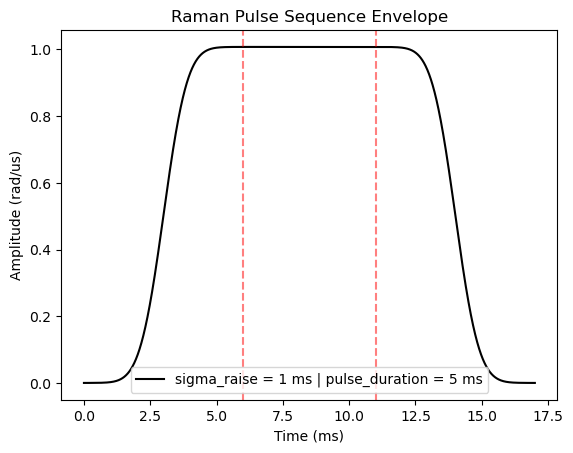

In [326]:
pulses, args_pulses = [], []
pulses.append('ft')
pulses.append('ft')

sigma_raise = 1000
pulse_duration = 5000
t0 = pulse_duration/2+sigma_raise*6
t = np.linspace(0, t0*2, int(t0/3))
args_pulses.append({
    'sigma_raise': sigma_raise,
    'amplitude': amp1,
    'detuning': -(A)/2 - Delta + resonant_freq,
    'pulse_duration': pulse_duration,
    't0': t0,
    'phase': 0
})
args_pulses.append({
    'sigma_raise': sigma_raise,
    'amplitude': amp2,
    'detuning': -(A)/2 - Delta,
    'pulse_duration': pulse_duration,
    't0': t0,
    'phase': 0
})
seq_args = {"pulses": pulses, "args_pulses": args_pulses}

seq_args["args_pulses"][0]["detuning"] = 0
seq_args["args_pulses"][1]["detuning"] = 0
p = [pulse_sequence_p(_t, seq_args) for _t in t]
plt.title("Raman Pulse Sequence Envelope")
plt.plot(t/1000, p, 'k', alpha=1, label = 'sigma_raise = %.f ms | pulse_duration = %.f ms'%(sigma_raise/1000, pulse_duration/1000))
plt.axvline(x = sigma_raise*6/1000, color = 'red', linestyle = '--', alpha = 0.5)
plt.axvline(x = (sigma_raise*6+pulse_duration)/1000, color = 'red', linestyle = '--', alpha = 0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (rad/us)")
plt.legend(loc = 'lower center')
plt.savefig('plots\Raman_Pulse_Sequence_%.f.png'%(Delta/2/np.pi*1000), dpi=600, bbox_inches='tight')

In [287]:
# resonant_freq = 808.549/1000*2*np.pi
# n_points = 5
# pulse_duration = np.linspace (1, 100000, n_points)
pulse_duration=50000

# square pulse time
t0 = pulse_duration/2+sigma_raise*3
t = np.linspace(0, t0*2, int(t0))

# flattop pulse time
# t0 = pulse_duration/2+sigma_raise*6
# t = np.linspace(0, t0*2, int(t0/2))

import time

start_time = time.time()

pulses, args_pulses = [], []
pulses.append('s')
pulses.append('s')

args_pulses.append({
    'sigma_raise': sigma_raise,
    'amplitude': amp1,
    'detuning': (A)/2 - Delta + resonant_freq,
    'pulse_duration': pulse_duration+sigma_raise*6,
    't0': t0,
    'phase': 0
})
args_pulses.append({
    'sigma_raise': sigma_raise,
    'amplitude': amp2,
    'detuning': (A)/2 - Delta,
    'pulse_duration': pulse_duration+sigma_raise*6,
    't0': t0,
    'phase': 0
})
seq_args = {"pulses": pulses, "args_pulses": args_pulses}

H_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
H_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]
H = [H0, H_p, H_m]
ket0 = H0.eigenstates()[1][3] # down-down state

gamma_R = (0.8*1000)**-1 # (0.8 ms)**-1
n_thermal_photon = 0.01
c_ops = []
c_ops.append(np.sqrt(gamma_R) * sigmam_nuclear_up)
c_ops.append(np.sqrt(gamma_R) * sigmam_nuclear_down)
c_ops.append(np.sqrt(gamma_phi)*tensor(sigmaz(), qeye(nS)))
c_ops.append(np.sqrt(gamma_R * n_thermal_photon) * sigmam_nuclear_up.dag())
c_ops.append(np.sqrt(gamma_R * n_thermal_photon) * sigmam_nuclear_up.dag())

gamma_phi = 0 * (1*1000)**-1 # (ms)**-1
# c_ops = [np.sqrt(gamma_R) * sigmam_nuclear_up, np.sqrt(gamma_R) * sigmam_nuclear_down, np.sqrt(gamma_R/5) * 2.5 * cross_nuclear_d2u, np.sqrt(gamma_R/5) * 2.5 * cross_nuclear_u2d]

result = mesolve(H, ket0, t, c_ops, [], args=seq_args)

# pool = Pool(worker_count)
# args = [(H, ket0, t, c_ops, dur, sigma_raise, seq_args, Sz, nS) for dur in [pulse_duration]]
# result = pool.starmap(mp_raman_rabi_s, args)
# pool.close()

end_time = time.time()
print("Run time: %.2f min"%((end_time - start_time)/60))

raman_rabi_s = expect(tensor(qeye(nS), Sz), result.states)
electron_pop = expect(tensor(Sz, qeye(nS)), result.states)

Run time: 2.43 min


In [271]:
def decay_rabi_fit(t,f,gamma,a,b):
    return -a*(np.cos(2*np.pi*f*t)) * np.exp(-t/gamma) + b

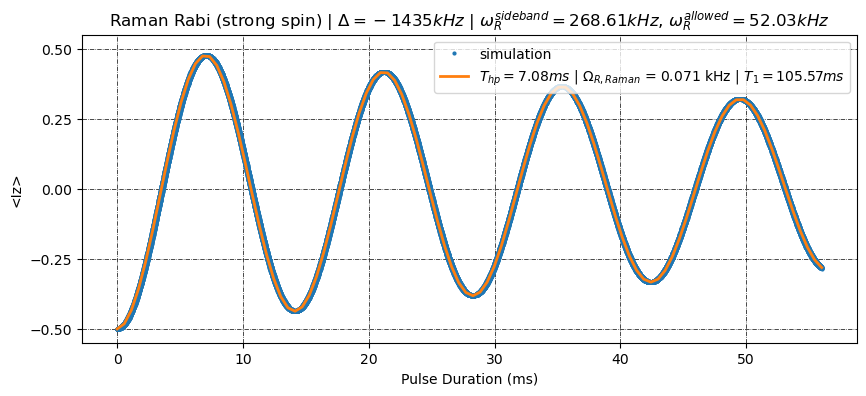

In [288]:
fit_axis = np.linspace (0, t[-1]/1000, 100)

plt.figure(figsize = (10,4))
plt.title("Raman Rabi (strong spin) | $\Delta=%.f kHz$ | $\omega_{R}^{sideband}=%.2f kHz$, $\omega_{R}^{allowed}=%.2f kHz$"%(Delta/2/np.pi*1e3, amp1/2/np.pi*1000, amp2/2/np.pi*1000))
plt.plot(t/1000, raman_rabi_s, 'o', markersize = 2, label = 'simulation')
# guess = [raman_rabi_freq_guess, 0.5, 0, 0]

raman_rabi_freq_guess = amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/abs(Delta*1000/2/np.pi) - amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/(abs(Delta*1000/2/np.pi)+774)
decay_guess = [raman_rabi_freq_guess, 8, 0.5, 0]
popt, pcov = curve_fit(decay_rabi_fit, t/1000, raman_rabi_s, decay_guess)
label = "$T_{hp} = %.2f ms$ | $\Omega_{R,Raman}$ = %.3f kHz | $T_1=%.2f ms$"%(1/popt[0]/2, popt[0], popt[1])
plt.plot(fit_axis, decay_rabi_fit(fit_axis, *popt), label=label, linewidth = 2)

plt.grid(color='k', linestyle='-.', linewidth=0.5)
plt.ylim(-0.55, 0.55)
plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.xlabel("Pulse Duration (ms)")
plt.ylabel("<Iz>")
plt.legend(loc = 'upper right')

In [385]:
def exp_decay(t,gamma, a, b):
    return a* np.exp(-t/gamma) + b

array([ 6.90700027e-02,  1.34807213e+02,  8.57669191e-03, -4.86433971e-01])

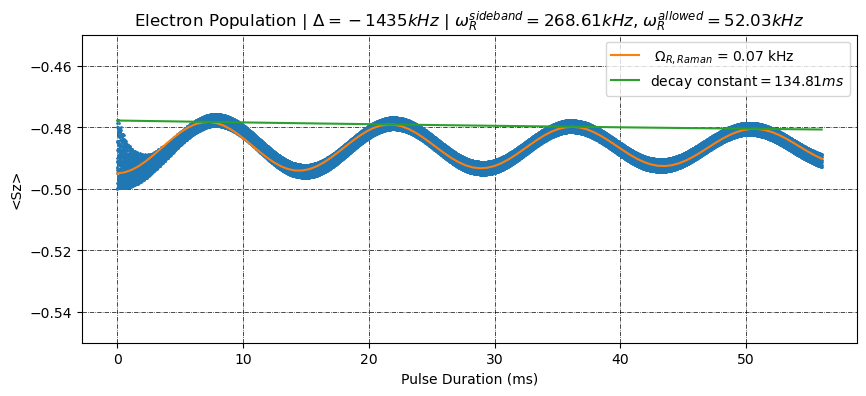

In [298]:
%matplotlib inline
fit_axis = np.linspace (0, t[-1]/1000, 100)

plt.figure(figsize = (10,4))
plt.title("Electron Population | $\Delta=%.f kHz$ | $\omega_{R}^{sideband}=%.2f kHz$, $\omega_{R}^{allowed}=%.2f kHz$"%(Delta/2/np.pi*1e3, amp1/2/np.pi*1000, amp2/2/np.pi*1000))
plt.plot(t/1000, electron_pop, 'o', markersize = 1)

raman_rabi_freq_guess = amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/abs(Delta*1000/2/np.pi) - amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/(abs(Delta*1000/2/np.pi)+774)
guess = [raman_rabi_freq_guess, 8, 0.5, 0]
popt, pcov = curve_fit(decay_rabi_fit, t/1000, electron_pop, guess)
label = " $\Omega_{R,Raman}$ = %.2f kHz"%(popt[0])
plt.plot(fit_axis, decay_rabi_fit(fit_axis, *popt), label=label)
label = "decay constant$=%.2f ms$"%(popt[1])
plt.plot(fit_axis, exp_decay(fit_axis, *[popt[1], popt[2], popt[3]]), label=label)

plt.grid(color='k', linestyle='-.', linewidth=0.5)
plt.ylim(-0.55, -0.45)
# plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.xlabel("Pulse Duration (ms)")
plt.ylabel("<Sz>")
plt.legend(loc = 'upper right')
popt

# Raman Detuning Dependence

In [39]:
Delta = 1.566*2*np.pi # MHz * 2pi
allowed_detuning = 1400/1000*2*np.pi         # MHz * 2pi
sideband_detuning = (809+1400)/1000*2*np.pi         # MHz * 2pi
kappa = 4.41        # us-1
allowed_cavity_filter = 1/np.sqrt(1+(2*allowed_detuning/kappa)**2)
sideband_cavity_filter = 1/np.sqrt(1+(2*sideband_detuning/kappa)**2)
drive_amp_convert = 107/0.05 # conversion between drive amp in kHz and relative amp 

electron_amplitude = 0.1
sideband_amplitude = 1

sigma_raise = 1000
amp1 = sideband_amplitude*drive_amp_convert*sideband_cavity_filter /1000*2*np.pi # MHz * 2pi
amp2 = electron_amplitude*drive_amp_convert*allowed_cavity_filter /1000*2*np.pi # MHz * 2pi
print(amp1*1e3/2/np.pi, amp2*1e3/2/np.pi)

Delta_list = np.linspace(-1566, -1567, 2)*2*np.pi/1000
amp_list = np.linspace(0.05, 0.03, 5)

335.7641307299119 52.033321118230056


  0%|          | 0/5 [00:00<?, ?it/s]

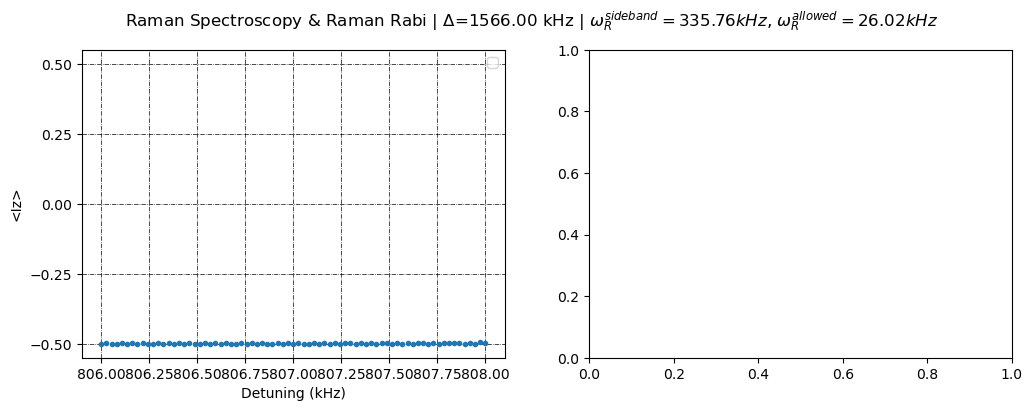

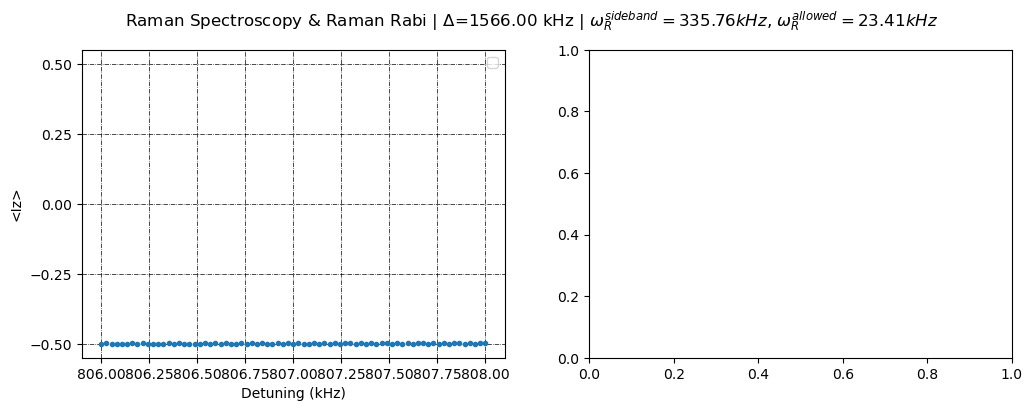

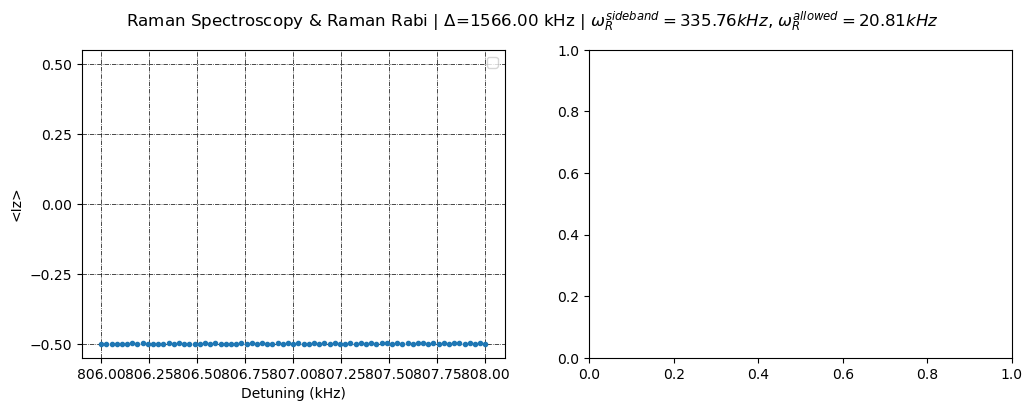

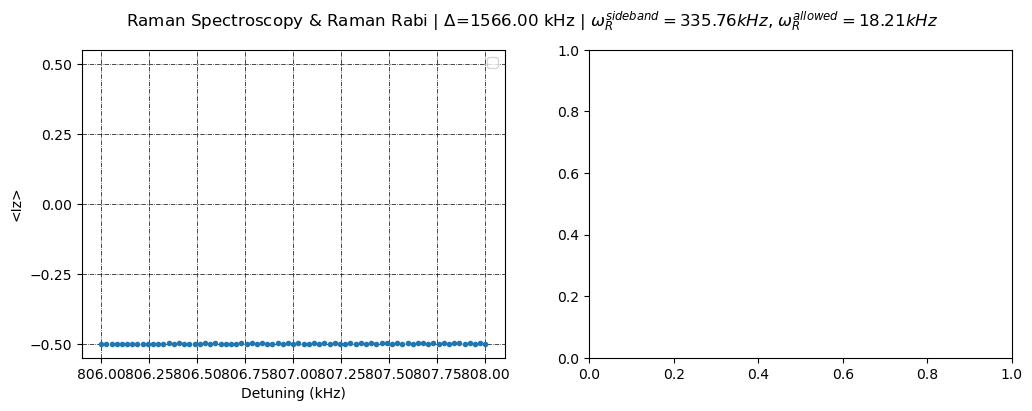

capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: Fatal Python error: F2PySwapThreadLocalCallbackPtrF2PySwapThreadLocalCallbackPtr: : F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failedF2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed

Python runtime state: Python runtime state: initializedinitialized

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Traceback (most recent call last):
Traceback (most recent call last):
capi_return is NULL
  File "qutip/cy/cqobjevo.pyx", line 212, in qutip.cy.cqobjevo.CQobjEvo.mul_vec
  File "qutip/cy/cqobjevo.pyx", line 212, in qutip.cy.cqobjevo.CQobjEvo.mul_vec
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime sta

KeyboardInterrupt: 

.optimize._highs._highs_constants, scipy.linalg._interpolative, scipy.optimize._bglu_dense, scipy.optimize._lsap, scipy.spatial._ckdtree, scipy.spatial._qhull, scipy.spatial._voronoi, scipy.spatial._distance_wrap, scipy.spatial._hausdorff, scipy.spatial.transform._rotation, scipy.optimize._direct, scipy.interpolate._bspl, scipy.interpolate._ppoly, scipy.interpolate.interpnd, scipy.interpolate._rbfinterp_pythran, scipy.interpolate._rgi_cython, qutip.cy.inter, qutip.cy.cqobjevo_factor, qutip.cy.cqobjevo, qutip.cy.graph_utils  File "/Users/willhuang/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/willhuang/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/willhuang/anaconda3/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
, matplotlib._image  File "/Users/willhuang/anaconda3/lib/python3.11/multiprocessi

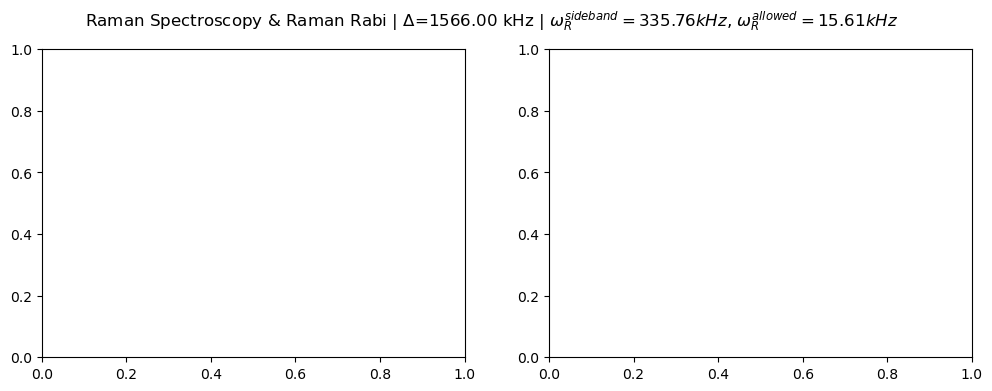

In [40]:
raman_rabi_freq = []
spec = []
rabi = []
elec = []
for rel_amp in tqdm(amp_list):
    amp2 = rel_amp*drive_amp_convert*allowed_cavity_filter /1000*2*np.pi # MHz * 2pi
    
    raman_rabi_freq_guess = amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/abs(Delta*1000/2/np.pi) - amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/(abs(Delta*1000/2/np.pi+774))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("Raman Spectroscopy & Raman Rabi | $\Delta$=%.2f kHz | $\omega_{R}^{sideband}=%.2f kHz$, $\omega_{R}^{allowed}=%.2f kHz$"%(Delta*1000/2/np.pi,amp1/2/np.pi*1000, amp2/2/np.pi*1000))
    
    ############################ Raman Spectroscopy ############################
    spec_pulse_duration = 10000
    spec_detuning = np.linspace(806, 808, 75)/1000*2*np.pi

    pulses, args_pulses = [], []
    ############## Sideband ##############
    pulses.append('s')
    args_pulses.append({
        'sigma_raise': sigma_raise,
        'pulse_duration': spec_pulse_duration,
        'amplitude': amp1,
        't0': 0,
        'detuning': 0,
        'phase': 0,
    })
    ############## Allowed ##############
    pulses.append('s')
    args_pulses.append({
        'sigma_raise': sigma_raise,
        'pulse_duration': spec_pulse_duration,
        'amplitude': amp2,
        't0': 0,
        'detuning': 0,
        'phase': 0,
    })
    seq_args = {"pulses": pulses, "args_pulses": args_pulses}
    H_flattop_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
    H_flattop_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]
    H = [H0, H_flattop_p, H_flattop_m]
    ket0 = H0.eigenstates()[1][3]

    pool = Pool(worker_count)
    args = [(H, ket0, spec_pulse_duration, sigma_raise, det, -A, Delta, seq_args, Sz, nS) for det in spec_detuning]
    I_z = pool.starmap(mp_raman_spec_s, args)
    pool.close()
    spec.append(I_z)
    
    x = spec_detuning/2/np.pi*1000 # to kHz
    fit_axis = np.linspace(x[0],x[-1],1000)
    chevron_guess = [get_peak_center(x, I_z), raman_rabi_freq_guess, 16]
    # guess = [get_peak_center(x, I_z), 0.1, -0.5, np.max(I_z)]
    guess = [x[np.argmin(I_z)], amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/385, -0.5, np.max(I_z)]
    # popt, pcov = curve_fit(chevron, x, I_z, chevron_guess)
    label = r'$|\downarrow\downarrow\rangle$ | $\delta_0$ = %.3f kHz'%(popt[0])
    ax1.plot(x, I_z, 'o', markersize = 3)
    # ax1.plot(fit_axis, chevron(fit_axis, *popt), alpha = 1, linewidth = 1, label = label)
    ax1.grid(color='k', linestyle='-.', linewidth=0.5)
    ax1.set_ylim([-0.55, 0.55])
    ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
    ax1.set(xlabel = "Detuning (kHz)", ylabel = "<Iz>")
    ax1.legend()
    resonant_freq = popt[0]*2*np.pi/1000 # MHz * 2pi

#     ############################ Raman Rabi ############################
#     pulse_duration=30000

#     # square pulse time
#     t0 = pulse_duration/2+sigma_raise*3
#     t = np.linspace(0, t0*2, int(t0))
    
#     pulses, args_pulses = [], []
#     pulses.append('ft')
#     pulses.append('ft')

#     args_pulses.append({
#         'sigma_raise': sigma_raise,
#         'amplitude': amp1,
#         'detuning': -(A)/2 - Delta + resonant_freq,
#         'pulse_duration': pulse_duration+sigma_raise*6,
#         't0': t0,
#         'phase': 0
#     })
#     args_pulses.append({
#         'sigma_raise': sigma_raise,
#         'amplitude': amp2,
#         'detuning': -(A)/2 - Delta,
#         'pulse_duration': pulse_duration+sigma_raise*6,
#         't0': t0,
#         'phase': 0
#     })
#     seq_args = {"pulses": pulses, "args_pulses": args_pulses}

#     H_p = [tensor(sigmap(),qeye(nI)), pulse_sequence_p]
#     H_m = [tensor(sigmam(),qeye(nI)), pulse_sequence_m]
#     H = [H0, H_p, H_m]
#     ket0 = H0.eigenstates()[1][3] # down-down state

#     result = mesolve(H, ket0, t, [], [], args=seq_args)

#     raman_rabi_s = expect(tensor(qeye(nS), Sz), result.states)
#     electron_pop = expect(tensor(Sz, qeye(nS)), result.states)
#     rabi.append(raman_rabi_s)
#     elec.append(electron_pop)
    
#     fit_axis = np.linspace (0, t[-1]/1000, 100)
#     guess = [raman_rabi_freq_guess, 0.5, 0, 0]
#     popt, pcov = curve_fit(rabi_fit, t/1000, raman_rabi_s, guess)
#     if (popt[1] * (popt[2] - np.cos(0)) < 0):
#         min_Iz = popt[1] * (popt[2] - np.cos(0))
#         max_Iz = popt[1] * (popt[2] - np.cos(np.pi))
#     else:
#         max_Iz = popt[1] * (popt[2] - np.cos(0))
#         min_Iz = popt[1] * (popt[2] - np.cos(np.pi))
#     label = "$T_{hp} = %.2f ms$ | $\Omega_{R,Raman}$ = %.2f kHz \n max = %.2f | min  = %.2f"%(1/popt[0]/2, popt[0], max_Iz, min_Iz)
#     ax2.plot(t/1000, raman_rabi_s, 'o')
#     ax2.plot(fit_axis, rabi_fit(fit_axis, *popt), label=label)
#     ax2.grid(color='k', linestyle='-.', linewidth=0.5)
#     ax2.set_ylim([-0.55, 0.55])
#     ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
#     ax2.set(xlabel = "Pulse Duration (ms)")
#     ax2.legend(loc = 'upper right')
    
#     raman_rabi_freq.append(popt[0])
    plt.show()

In [52]:
# np.savetxt('single_nucleus_simulation_data/Delta_list_widescan.txt', Delta_list)
# np.savetxt('single_nucleus_simulation_data/raman_rabi_freq_widescan.txt', raman_rabi_freq)

# np.savetxt('single_nucleus_simulation_data/spec.txt', spec)
# np.savetxt('single_nucleus_simulation_data/rabi.txt', rabi)

In [38]:
raman_rabi_freq = []

for ii, Delta in enumerate((Delta_list)):

    I_z = spec[ii][:]
    raman_rabi_s = rabi[ii][:]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("Raman Spectroscopy & Raman Rabi | $\Delta$=%.2f kHz | $\omega_{R}^{sideband}=%.2f kHz$, $\omega_{R}^{allowed}=%.2f kHz$"%(Delta*1000/2/np.pi,amp1/2/np.pi*1000, amp2/2/np.pi*1000))
    
    ############################ Raman Spectroscopy ############################
    
    spec_pulse_duration = 10000
    spec_detuning = np.linspace(808, 809.5, 75)/1000*2*np.pi

    x = spec_detuning/2/np.pi*1000 # to kHz
    fit_axis = np.linspace(x[0],x[-1],1000)
    raman_rabi_freq_guess = amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.048/2/abs(Delta*1000/2/np.pi) + amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.048/2/(abs(Delta*1000/2/np.pi-780))
    chevron_guess = [get_peak_center(x, I_z), raman_rabi_freq_guess, 16]
    # guess = [get_peak_center(x, I_z), 0.1, -0.5, np.max(I_z)]
    guess = [x[np.argmin(I_z)], amp1/2/np.pi*1000*amp2/2/np.pi*1000*0.04/2/385, -0.5, np.max(I_z)]
    popt, pcov = curve_fit(chevron, x, I_z, chevron_guess)
    label = r'$|\downarrow\downarrow\rangle$ | $\delta_0$ = %.3f kHz'%(popt[0])
    ax1.plot(x, I_z, 'o', markersize = 3)
    ax1.plot(fit_axis, chevron(fit_axis, *popt), alpha = 1, linewidth = 1, label = label)
    ax1.grid(color='k', linestyle='-.', linewidth=0.5)
    ax1.set_ylim([-0.55, 0.55])
    ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
    ax1.set(xlabel = "Detuning (kHz)", ylabel = "<Iz>")
    ax1.legend()
    resonant_freq = popt[0]*2*np.pi/1000 # MHz * 2pi

    ############################ Raman Rabi ############################

    rabi_pulse_duration = np.linspace (1, 30000, 30)
    
    fit_axis = np.linspace (0, t[-1]/1000, 100)
    guess = [raman_rabi_freq_guess, 0.5, 0, 0]
    popt, pcov = curve_fit(rabi_fit, t/1000, raman_rabi_s, guess)
    if (popt[1] * (popt[2] - np.cos(0)) < 0):
        min_Iz = popt[1] * (popt[2] - np.cos(0))
        max_Iz = popt[1] * (popt[2] - np.cos(np.pi))
    else:
        max_Iz = popt[1] * (popt[2] - np.cos(0))
        min_Iz = popt[1] * (popt[2] - np.cos(np.pi))

    label = "$T_{hp} = %.1f ms$ | $\Omega_{R,Raman}$ = %.3f kHz \n max = %.2f | min  = %.2f"%(1/popt[0]/2, popt[0], max_Iz, min_Iz)
    ax2.plot(t/1000, raman_rabi_s, 'o', markersize = 1)
    ax2.plot(fit_axis, rabi_fit(fit_axis, *popt), label=label)
    ax2.grid(color='k', linestyle='-.', linewidth=0.5)
    ax2.set_ylim([-0.55, 0.55])
    ax2.set_yticks(np.linspace(-0.5, 0.5, 5))
    ax2.set(xlabel = "Pulse Duration (ms)")
    ax2.legend(loc = 'upper right')
    
    raman_rabi_freq.append(abs(popt[0]))

IndexError: list index out of range